In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
from helpers import *

In [2]:
# path to project directory
path = Path('./')

In [3]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v5.csv', index_col=0, dtype={'season':str})

## XGBoost model

XGboost is another ensemble tree-based predictive algorithm that performs well across a range of applications. Preparation of the data is very similar to the random forest approach.

Again this is a time series problem, where metrics from recent time periods can be predicitve, wo we need to add in window features (e.g. points scored last gameweek).

In [4]:
# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], 
                                                    ['all', 1, 2, 3, 4, 5, 10])

We have introduced a number of lag (window) features for each player's points per game, their team's points per game and the opposition team's points per game over the previous 1, 2, 3, 4, 5, 10 and all gameweeks.

Next we can set the validation point and length as well as the categorical and continuous features we'll be using to predict the dependent variable, total points for each game. These are used in the create_lag_train function to get an our training set (including appropriate lag values in the validation set).

The gameweeks and seasons are ordered, so we want to have them as ordered categories with the correct order (2016-17 is before 2017-18 etc.).

In [5]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 20
valid_len = 6
# cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cat_vars = ['season', 'position', 'was_home']#,'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
cont_vars = ['gw', 'minutes']
dep_var = ['total_points']

In [6]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [7]:
from itertools import compress

mask = [x.startswith('total_points_team_pg_last_') for x in team_lag_vars]
list(compress(team_lag_vars, mask))

['total_points_team_pg_last_all',
 'total_points_team_pg_last_1',
 'total_points_team_pg_last_2',
 'total_points_team_pg_last_3',
 'total_points_team_pg_last_4',
 'total_points_team_pg_last_5',
 'total_points_team_pg_last_10',
 'total_points_team_pg_last_all_opponent',
 'total_points_team_pg_last_1_opponent',
 'total_points_team_pg_last_2_opponent',
 'total_points_team_pg_last_3_opponent',
 'total_points_team_pg_last_4_opponent',
 'total_points_team_pg_last_5_opponent',
 'total_points_team_pg_last_10_opponent']

In [8]:
# create dataset with adjusted post-validation lag numbers
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

In [9]:
# take a look at the dataframe
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 37 columns):
gw                                        82054 non-null category
minutes                                   82054 non-null int64
minutes_last_1                            81953 non-null float64
minutes_last_10                           81953 non-null float64
minutes_last_2                            81953 non-null float64
minutes_last_3                            81953 non-null float64
minutes_last_4                            81953 non-null float64
minutes_last_5                            81953 non-null float64
minutes_last_all                          81953 non-null float64
opponent_team                             82054 non-null object
player                                    82054 non-null object
position                                  82054 non-null int64
season                                    82054 non-null category
team                                      82054 no

We can now build the input (X) and dependent (y) variable datasets. Again this includes encoding the categorical features so that each level is represented in it's own column (e.g. postition_1, position_2, etc.).

In [10]:
# split out dependent variable
X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

In [11]:
# since position is categorical, it should be a string
X['position'] = X['position'].apply(str)

# need to transform season
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

You can see the resulting dataset with the categorical features split out into levels. This can now be used in the XGBoost API.

In [12]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 36 columns):
gw                                        82054 non-null float64
minutes                                   82054 non-null float64
minutes_last_1                            81953 non-null float64
minutes_last_10                           81953 non-null float64
minutes_last_2                            81953 non-null float64
minutes_last_3                            81953 non-null float64
minutes_last_4                            81953 non-null float64
minutes_last_5                            81953 non-null float64
minutes_last_all                          81953 non-null float64
position_1                                82054 non-null float64
position_2                                82054 non-null float64
position_3                                82054 non-null float64
position_4                                82054 non-null float64
season                                    8205

In [13]:
X[player_lag_vars + team_lag_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 28 columns):
minutes_last_all                          81953 non-null float64
minutes_last_1                            81953 non-null float64
minutes_last_2                            81953 non-null float64
minutes_last_3                            81953 non-null float64
minutes_last_4                            81953 non-null float64
minutes_last_5                            81953 non-null float64
minutes_last_10                           81953 non-null float64
total_points_pg_last_all                  68666 non-null float64
total_points_pg_last_1                    37877 non-null float64
total_points_pg_last_2                    44331 non-null float64
total_points_pg_last_3                    47806 non-null float64
total_points_pg_last_4                    50291 non-null float64
total_points_pg_last_5                    52086 non-null float64
total_points_pg_last_10                   5764

Once again we need to split out the validation set and use it after training to create predictions and calculate the error.

Finally we instatiate an XGBRegressor (since the dependent variable is continuous) and do a single train with arbitrary parameters.

In [14]:
# split out training and validation sets
X_train = X_df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X_df.iloc[valid_idx]
y_test = y.iloc[valid_idx]

In [15]:
# X_train_mins = X_train[X_train['minutes'] > 10]
# y_train_mins = y_train[X_train['minutes'] > 10]
# X_test_mins = X_test[X_test['minutes'] > 10]
# y_test_mins = y_test[X_test['minutes'] > 10]

In [16]:
# def xgb___(xs, y, gamma=0.3, learning_rate=0.08, max_depth=4, 
#         n_estimators=50, subsample=0.7, **kwargs):
#     return RandomForestRegressor(n_jobs=-1, gamma=gamma,
#         learning_rate=learning_rate, max_depth=max-depth,
#         n_estimators=n_estimators, subsample=subsample).fit(xs, y)

In [20]:
# instatiate and train XGB Regressor
# print result
# xg_reg = xgb.XGBRegressor(objective="reg:squarederror",
#                           gamma=0.043256447370879914, learning_rate=0.09131119220082666, 
#                           max_depth=5, n_estimators=103, subsample=0.6159698898484126)
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          gamma=0.3, learning_rate=0.08, max_depth=5, n_estimators=50, subsample=0.7)

xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))

RMSE: 1.785268


In [21]:
mae(preds, y_test['total_points'])
# mae(preds[X_test['minutes'] > 0], y_test[X_test['minutes'] > 0]['total_points'])

0.845572

This is another clear improvement on the previous best (random forest), but perhaps it can be improved by doing a parameter search.

To do this we will first define the grid of parameters to be searched.

In [17]:
# parameter search space
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

In this case we will pass both train and validation parts of the dataset, along with a series telling the XGBRegressor object which rows to use for training, and which for validation.

In [18]:
X_train = X_df
y_train = y
test_fold = np.repeat([-1, 0], [valid_idx[0], valid_idx[-1] - valid_idx[0] + 1])
ps = PredefinedSplit(test_fold)

In [115]:
X_df[test_fold == -1]

,gw,minutes,minutes_last_1,minutes_last_10,minutes_last_2,minutes_last_3,minutes_last_4,minutes_last_5,minutes_last_all,position_1,...,total_points_team_pg_last_2_opponent,total_points_team_pg_last_3,total_points_team_pg_last_3_opponent,total_points_team_pg_last_4,total_points_team_pg_last_4_opponent,total_points_team_pg_last_5,total_points_team_pg_last_5_opponent,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent,was_home
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78385,19.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,360.0,0.0,...,20.0,29.333333,19.333333,29.00,22.00,30.2,25.4,32.277778,37.222222,0.0
78386,19.0,45.0,13.0,382.0,13.0,89.0,89.0,89.0,6289.0,0.0,...,69.0,44.333333,59.666667,38.00,48.75,36.6,45.4,35.181818,45.055556,0.0
78387,19.0,0.0,0.0,459.0,39.0,100.0,171.0,261.0,4960.0,0.0,...,42.5,40.000000,35.000000,36.75,33.75,37.2,33.8,45.613636,38.393939,0.0
78388,19.0,85.0,75.0,366.0,81.0,81.0,81.0,81.0,1852.0,0.0,...,49.5,33.333333,42.000000,35.75,42.00,37.0,38.8,36.689394,49.977273,0.0


We can then again instatiate the XGBRegressor object, but this time pass it to a randomised search validation object, along with the parameter grid, validation splits, and number of iterations we want to run.

We then fit this to the training data - 25 random parameter selections will be made and the best parameters for the validation set can be found (may take a few minutes to run).

In [19]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                            param_distributions=params, 
                            scoring="neg_mean_squared_error", 
                            n_iter=100, 
                            cv=ps, 
                            verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 73.3min finished


Best parameters found:  {'gamma': 0.043256447370879914, 'learning_rate': 0.09131119220082666, 'max_depth': 5, 'n_estimators': 103, 'subsample': 0.6159698898484126}
Lowest RMSE found:  1.7842727744793694


In [22]:
X_df

,gw,minutes,minutes_last_1,minutes_last_10,minutes_last_2,minutes_last_3,minutes_last_4,minutes_last_5,minutes_last_all,position_1,...,total_points_team_pg_last_2_opponent,total_points_team_pg_last_3,total_points_team_pg_last_3_opponent,total_points_team_pg_last_4,total_points_team_pg_last_4_opponent,total_points_team_pg_last_5,total_points_team_pg_last_5_opponent,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent,was_home
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82049,25.0,0.0,0.0,10.0,0.0,10.0,10.0,10.0,625.0,0.0,...,25.5,35.000000,27.000000,37.25,27.75,45.2,27.8,38.452632,31.789474,1.0
82050,25.0,79.0,90.0,864.0,166.0,256.0,346.0,414.0,2752.0,0.0,...,44.0,24.333333,38.333333,33.00,35.50,39.6,36.8,40.533835,49.721805,1.0
82051,25.0,0.0,7.0,206.0,41.0,125.0,125.0,125.0,2033.0,0.0,...,43.0,28.666667,37.333333,30.50,32.75,33.2,39.2,35.242105,38.621212,0.0
82052,25.0,90.0,90.0,900.0,180.0,270.0,360.0,450.0,2081.0,0.0,...,44.0,24.333333,38.333333,33.00,35.50,39.6,36.8,40.533835,49.721805,1.0


Another reasonable improvement on the above.

The XGBoost package also allows us to look at features importance, just like with Random Forest in sklearn.

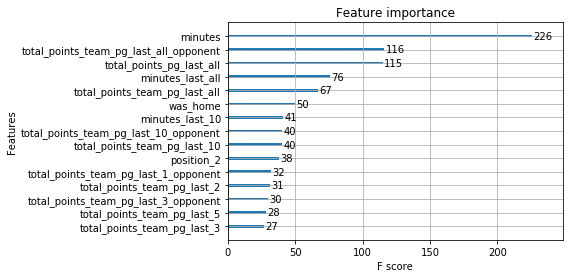

In [23]:
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

The top features look similar to previously, which is what we'd expect.

Now we can go ahead and run validation across the whole 2019/20 season.

In [24]:
def xgb_season(df, valid_season='1920'):
    # empty list for scores
    scores = []
    valid_len = 6

    for valid_gw in range(1,34):
        # create dataset with adjusted post-validation lag numbers
        train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                        cat_vars, cont_vars, 
                                                        player_lag_vars, team_lag_vars, dep_var,
                                                        valid_season, valid_gw, valid_len)

        X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

        # since position is categorical, it should be a string
        X['position'] = X['position'].apply(str)

        # need to transform season
        enc = LabelEncoder()
        X['season'] = enc.fit_transform(X['season'])
        X_dict = X.to_dict("records")

        # Create the DictVectorizer object: dv
        dv = DictVectorizer(sparse=False, separator='_')

        # Apply dv on df: df_encoded
        X_encoded = dv.fit_transform(X_dict)

        X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

        # split out training and validation sets
        X_train = X_df.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X_df.iloc[valid_idx]
        y_test = y.iloc[valid_idx]

        # instatiate and train XGB Regressor
#         xg_reg = xgb.XGBRegressor(objective="reg:squarederror",
#                                   gamma=0.05, learning_rate=0.09, max_depth=5, n_estimators=103, subsample=0.62)
        xg_reg = xgb.XGBRegressor(objective="reg:squarederror",
                                  gamma=0.42, learning_rate=0.047, max_depth=4, n_estimators=171, subsample=0.6)

        xg_reg.fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        gw_mae = mae(preds, y_test['total_points'])
        print("GW%d MAE: %f" % (valid_gw, gw_mae))

        scores.append(gw_mae)
        
    return scores


In [25]:
scores = xgb_season(lag_train_df)

GW1 MAE: 1.021820
GW2 MAE: 1.000417
GW3 MAE: 1.014818
GW4 MAE: 0.962099
GW5 MAE: 0.990377
GW6 MAE: 1.001582
GW7 MAE: 0.970430
GW8 MAE: 0.983534
GW9 MAE: 0.957087
GW10 MAE: 0.972183
GW11 MAE: 0.964617
GW12 MAE: 0.945771
GW13 MAE: 0.945942
GW14 MAE: 0.933869
GW15 MAE: 0.904744
GW16 MAE: 0.889615
GW17 MAE: 0.868028
GW18 MAE: 0.867757
GW19 MAE: 0.851423
GW20 MAE: 0.851141
GW21 MAE: 0.862401
GW22 MAE: 0.848762
GW23 MAE: 0.863959
GW24 MAE: 0.861853
GW25 MAE: 0.856602
GW26 MAE: 0.830153
GW27 MAE: 0.834965
GW28 MAE: 0.834843
GW29 MAE: 0.819144
GW30 MAE: 0.835185
GW31 MAE: 0.818470
GW32 MAE: 0.820157
GW33 MAE: 0.796688


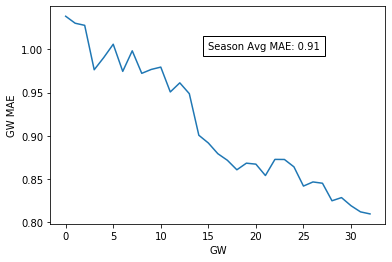

In [80]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

It appears that the improvement is sustained across the whole season, which is good to see, and we see the same improvement in performance across the season.

Again, we'll add these scores to the comparison dataset.

In [5]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['xgboost'] = scores
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

Finally, in the next notebook we'll move away from tree-based algorithms and try a neural network with embeddings.